# Purpose:
- Analyze hydration-driven z-drift divergence in cre lines other than GAD2-Cre
- From VisualBehaviorMultiscope, 2x4 configuration


In [1]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
from pymongo import MongoClient
from visual_behavior import database as db
from datetime import datetime
import seaborn as sns

mongo = MongoClient('flaskapp.corp.alleninstitute.org', 27017)

save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')

def get_depth_region_from_db(oeid):
    query = '''
    SELECT oe.id, st.acronym, oe.calculated_depth, imd.depth
    FROM ophys_experiments oe
    JOIN structures st ON st.id = oe.targeted_structure_id
    JOIN imaging_depths imd ON imd.id = oe.imaging_depth_id
    WHERE oe.id = {}
    '''.format(oeid)
    lims_results = db.lims_query(query)
    return lims_results.depth.values[0], lims_results.acronym.values[0]


def get_zdrift_results(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
        
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

def get_zdrift_results_first_last(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}_first_last.h5'
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids


# Select dataset

In [2]:
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')
session_ids = vbms_table.groupby('ophys_session_id').size()
session_ids = session_ids[session_ids == 8].index
table = vbms_table.query('ophys_session_id in @session_ids')
print(len(table))

2080


In [12]:
table.groupby('session_type').size()

session_type
OPHYS_0_images_A_habituation         8
OPHYS_1_images_A                   328
OPHYS_2_images_A_passive           304
OPHYS_2_images_B_passive             8
OPHYS_3_images_A                   336
OPHYS_4_images_B                   352
OPHYS_5_images_A_passive             8
OPHYS_5_images_B_passive           232
OPHYS_6_images_A                     8
OPHYS_6_images_B                   272
OPHYS_7_receptive_field_mapping    216
SNR_9                                8
dtype: int64

In [5]:
table = table[table.session_type.str.contains('OPHYS_') & ~table.session_type.str.contains('OPHYS_0')]

In [14]:
table.groupby('full_genotype').apply(lambda x: len(x.mouse_id.unique()))

full_genotype
Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    11
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                9
Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt               11
dtype: int64

In [42]:
# prepare dataframe to be passed to multi_plane_drift_sbatch.py
table = table[['mouse_id','ophys_session_id', 'full_genotype', 'session_type']].drop_duplicates()
for osid in table.ophys_session_id.values:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' not in session:
        if table.query('ophys_session_id == @osid').session_type.str.contains('OPHYS_7').values[0]:
            water = 0
        elif table.query('ophys_session_id == @osid').session_type.str.contains('passive').values[0]:
            water = 0
        else:
            raise ValueError(f'no change detection data for {osid}')
    else:
        water = session['change_detection']['total_reward_volume']
    table.loc[table.ophys_session_id == osid, 'water'] = water
    

In [44]:
table.to_csv(save_dir / 'multi_plane_zdrift_vb_multiscope.csv', index=False)

In [6]:
load_csv = save_dir / 'multi_plane_zdrift_vb_multiscope.csv'
table = pd.read_csv(load_csv)
len(table)

258

# Some sessions errored out
- 23 / 258 sessions errored out
- Just use the remaining 235 sessions

In [2]:
job_records_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\job_records')

# filter by created time, if needed
time_since = datetime(2024, 3, 26, 15, 0, 0)
# from job_dir get files created after time_since
files = [f for f in job_records_dir.glob('**/*') if f.is_file() and f.stat().st_ctime > time_since.timestamp()]

failed_files = []
failed_osids = []
success_word = 'total time ='
for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
        if np.array([success_word in l for l in lines]).any():
            pass
        else:
            failed_files.append(file)
            failed_osids.append(int(file.name.split('_')[-1].split('.')[0]))
failed_osids = np.unique(failed_osids)

In [3]:
failed_osids

array([ 841778484,  842023261,  842364341,  843871999,  844469521,
        852070825,  856201876,  870762788,  871906231,  873247524,
        873720614,  874616920,  875259383,  917886781,  918180797,
        924644503,  927620400,  942628468,  974167263,  976061108,
       1001385706, 1047935100, 1050231786])

In [4]:
load_csv = save_dir / 'multi_plane_zdrift_vb_multiscope.csv'
table = pd.read_csv(load_csv)
table = table[~table.ophys_session_id.isin(failed_osids)]
len(table)

235

In [7]:
table.head()

,mouse_id,ophys_session_id,full_genotype,session_type,water
0,457841,952430817,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_2_images_A_passive,0.000
1,457841,954954402,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_3_images_A,0.396
2,457841,960475921,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_7_receptive_field_mapping,0.000
3,457841,957020350,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_4_images_B,0.515
4,457841,955775716,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_3_images_A,0.445


In [6]:
succeeded_osids = np.setdiff1d(table.ophys_session_id.values, failed_osids)
len(succeeded_osids)

235

In [11]:
not_processed_opids = []
not_processed_osids = []
for osid in succeeded_osids:
    opids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    for opid in opids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(opid)
        except:
            ocid = 'none'
        zdrift_opid_dir = zdrift_dir / f'container_{ocid}' / f'experiment_{opid}'
        zdrift_first_last_fn = zdrift_opid_dir / f'{opid}_zdrift_ref_{opid}_first_last.h5'
        if not zdrift_first_last_fn.exists():
            not_processed_opids.append(opid)
            not_processed_osids.append(osid)
    

In [12]:
np.unique(not_processed_osids)

array([], dtype=float64)

In [13]:
not_processed_opids

[]

### All 235 osids were run correctly

## example time-series plot
- One example per cre line, divided into VISp and VISl, with or without water

In [3]:
# Load tables
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
load_fn = zdrift_dir / 'multi_plane_zdrift_vb_multiscope_processed.csv'
table = pd.read_csv(load_fn)

In [4]:
table.columns

Index(['mouse_id', 'ophys_session_id', 'full_genotype', 'session_type',
       'water', 'processed'],
      dtype='object')

In [11]:
vbms_table.targeted_structure.unique()

array(['VISp', 'VISl'], dtype=object)

In [4]:
table = table.query('processed == True')
print(len(table))

237


In [5]:
sst_table = table[table.full_genotype.str.contains('Sst')]
print(len(sst_table.mouse_id.unique()))

9


In [9]:
sst_table.water.max()

0.62

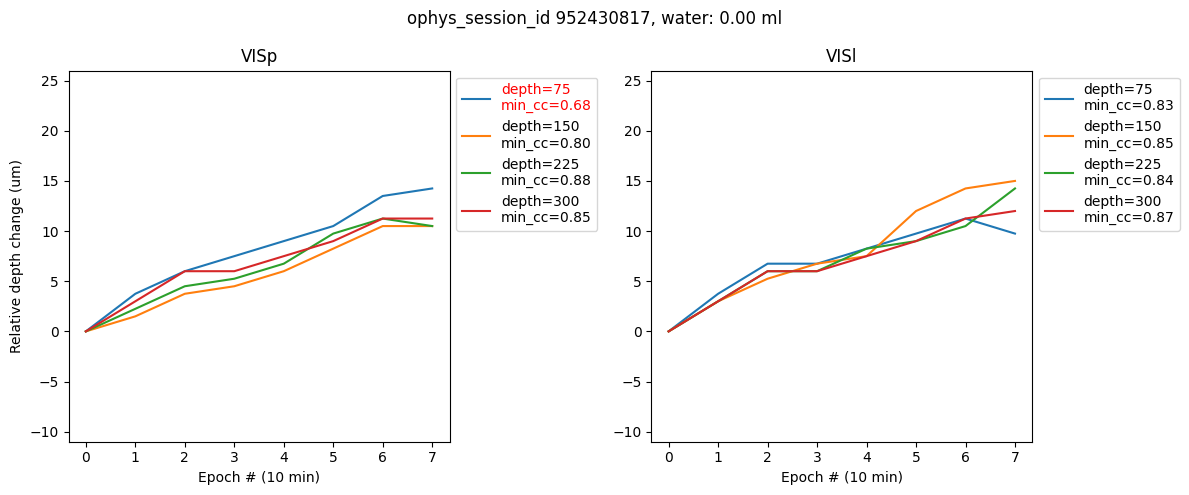

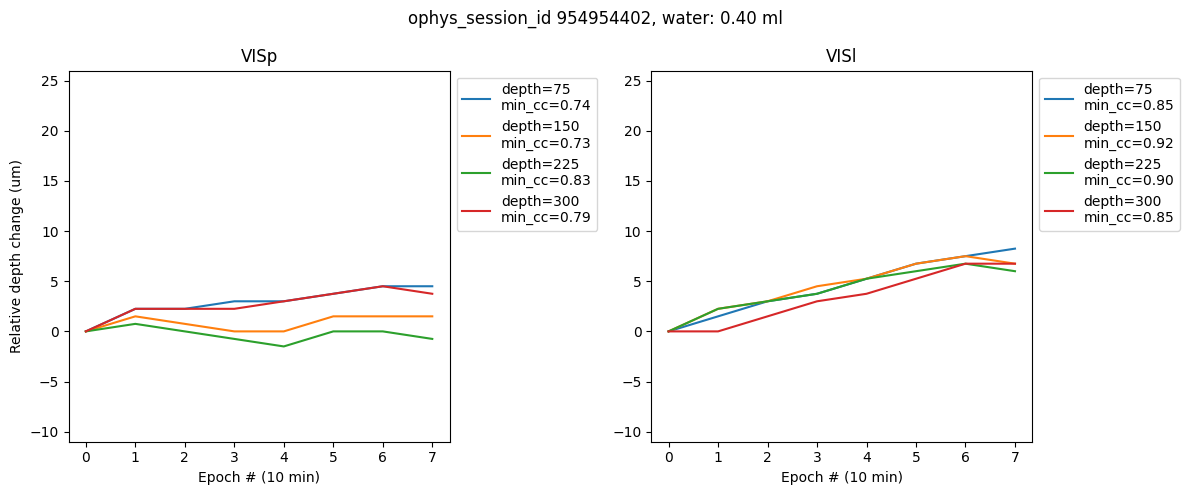

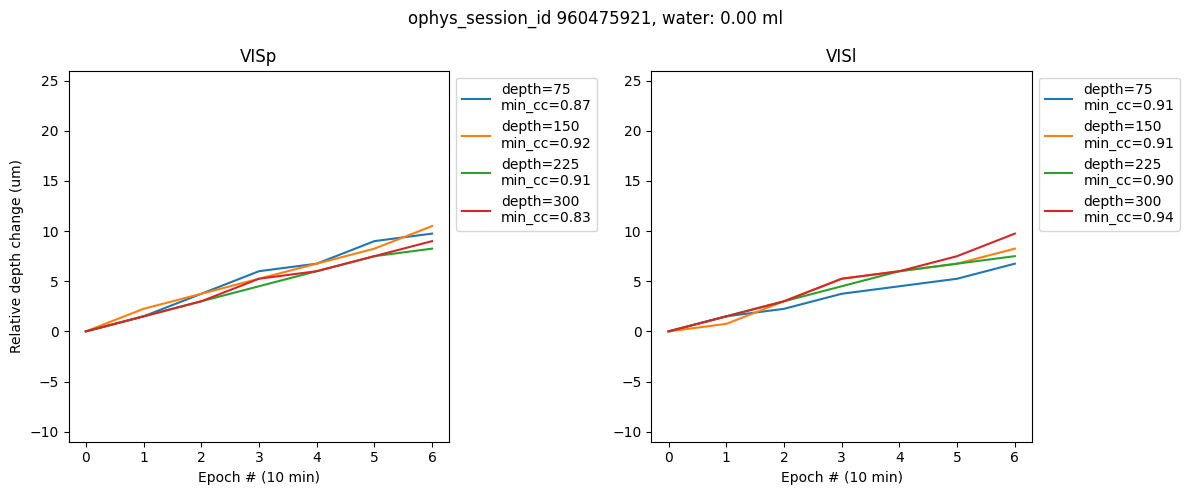

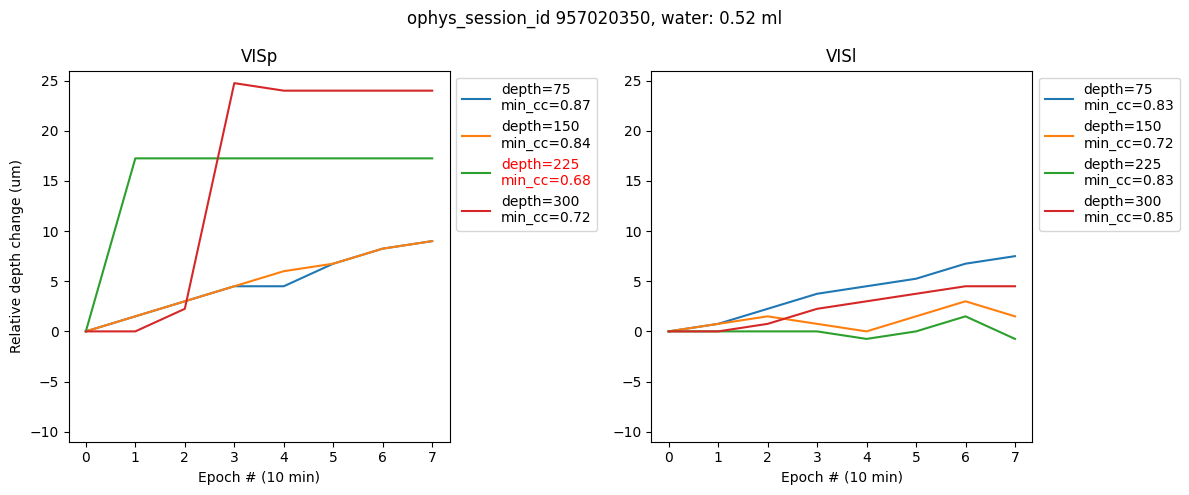

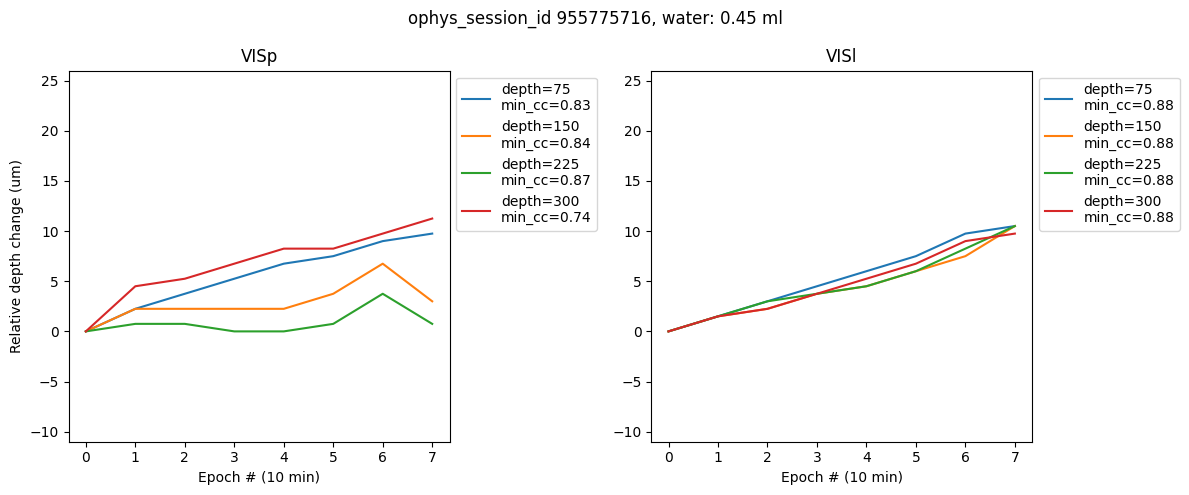

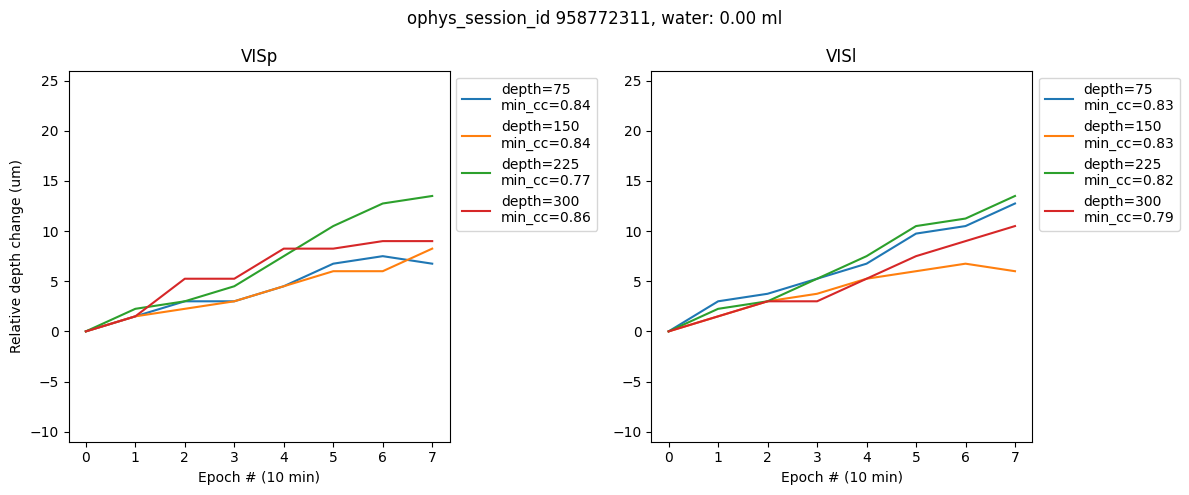

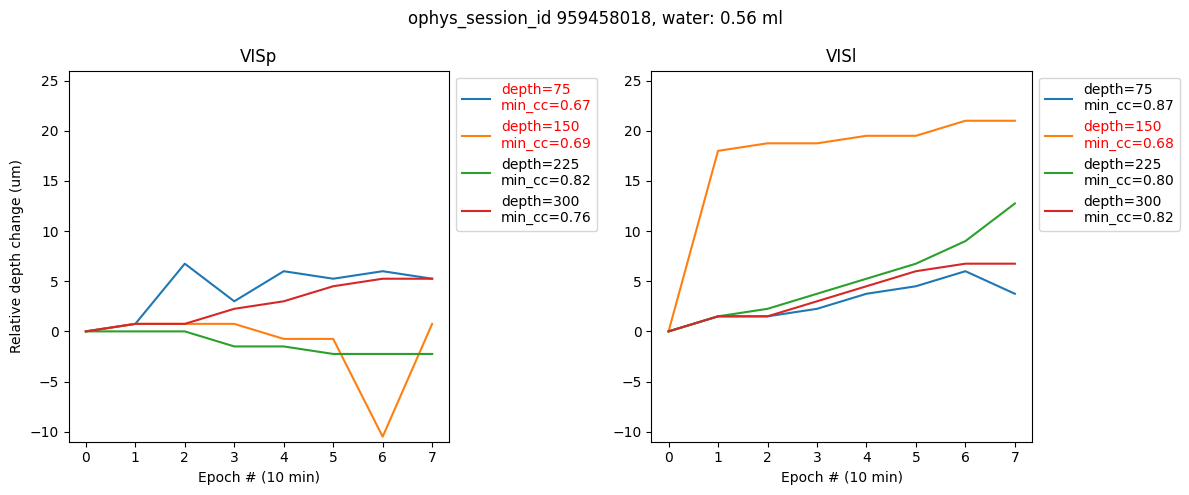

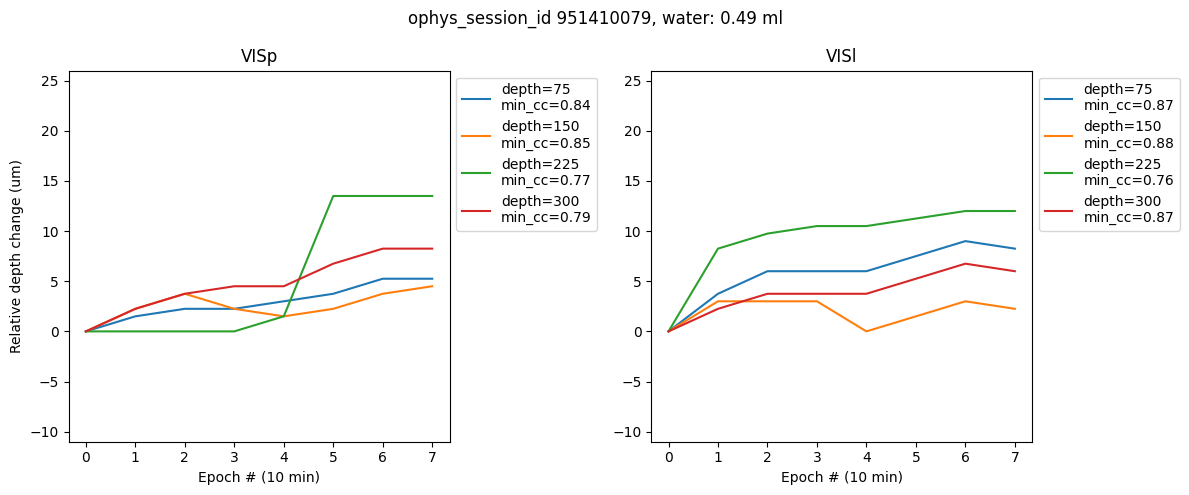

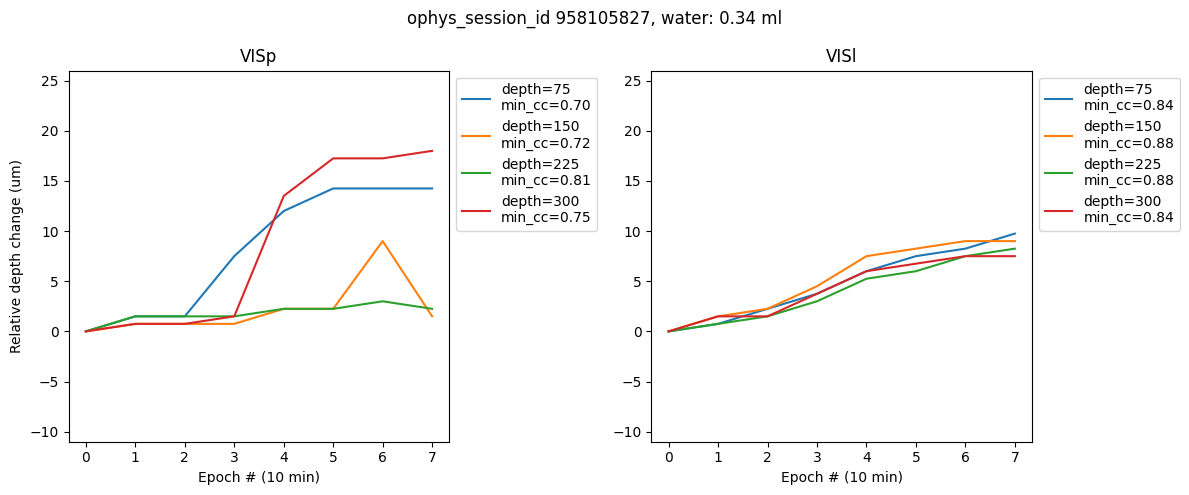

In [27]:
targeted_structures = ['VISp', 'VISl']
# mouse_id = sst_table[sst_table.water == sst_table.water.max()].mouse_id.values[0]
mouse_id = sst_table.mouse_id.unique()[0]
osids = sst_table[sst_table.mouse_id == mouse_id].ophys_session_id.values
oeid_all = []
cc_all = []
depth_all = []
water_all = []
for osid in osids:
    water_all.append(table.query('ophys_session_id == @osid').water.values[0])
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, zdrift_dir)
    relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
    cc_all.append(corrcoef)
    oeid_all.append(oeids)
    depth_all.append(relative_depth_change)

depth_range = (round(np.min([np.min(d) for d in depth_all]))-1, round(np.max([np.max(d) for d in depth_all]))+1)

for osid_i in range(len(osids)):
    osid = osids[osid_i]
    oeid = oeid_all[osid_i]
    corrcoef = cc_all[osid_i]
    relative_depth_change = depth_all[osid_i]
    water = water_all[osid_i]
    depth = []
    region = []
    for oeid in oeids:
        depth.append(vbms_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0])
        region.append(vbms_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0])
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    for i in range(2):
        target = targeted_structures[i]
        temp_inds = np.where(np.array(region) == target)[0]
        temp_depths = np.array(depth)[temp_inds]
        temp_order = np.argsort(temp_depths)
        min_cc = [np.min(corrcoef[ti]) for ti in temp_inds]
        for oi in temp_order:
            ax[i].plot(relative_depth_change[temp_inds[oi]],
                       label=f'depth={temp_depths[oi]}\nmin_cc={min_cc[oi]:.2f}')
        ax[i].set_title(target)
        ax[i].set_ylim(depth_range[0], depth_range[1])
        legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))
        
        for j, text in enumerate(legend.get_texts()):
            if min_cc[temp_order[j]] < 0.7:
                text.set_color('red')
        ax[i].set_xlabel('Epoch # (10 min)')
    ax[0].set_ylabel('Relative depth change (um)')
    fig.suptitle(f'ophys_session_id {osid}, water: {water:.2f} ml')
    fig.tight_layout()


## Water uptake distribution

Text(0, 0.5, 'Cumulative distribution')

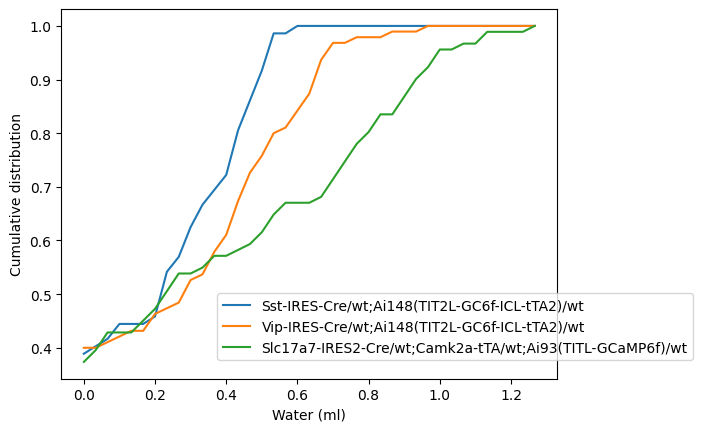

In [9]:
bins = np.linspace(0, 1.3, 40)
genotypes = table.full_genotype.unique()
fig, ax = plt.subplots()
for genotype in genotypes:
    temp_water = table.query("full_genotype == @genotype").water.values
    water_hist, _ = np.histogram(temp_water, bins=bins)
    water_cumhist = np.cumsum(water_hist) / np.sum(water_hist)
    ax.plot(bins[:-1], water_cumhist, label=genotype)
ax.legend(loc='upper left', bbox_to_anchor=(0.3,0.25))
ax.set_xlabel('Water (ml)')
ax.set_ylabel('Cumulative distribution')


In [15]:
# adding GAD2 neurons
cache = bpc.from_lims()
all_table = cache.get_ophys_experiment_table(passed_only=False)
lamf_table = all_table.query('project_code == "LearningmFISHTask1A"')
lamf_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]
last_run_time = datetime(2024, 2, 28, 0, 0, 0)
lamf_zdrift_run_table = lamf_table[lamf_table.apply(lambda x: pd.to_datetime(x.date_of_acquisition) < last_run_time, axis=1)].groupby(
    'ophys_session_id').apply(
    lambda x: len(x.targeted_structure.unique())<=2)

In [16]:
lamf_zdrift_run_table.head()

ophys_session_id
1153529245    False
1153776022    False
1154000392    False
1154245678    False
1154460714    False
dtype: bool

In [19]:
gad2_osids = lamf_zdrift_run_table[lamf_zdrift_run_table].index.values
gad2_water_recorded_osid = []
gad2_water_volume = []
for osid in gad2_osids:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' in session.keys():
        try:
            if 'total_water' in session['change_detection'].keys():
                total_water = session['change_detection']['total_water']
                earned_water = session['change_detection']['earned_water']
            else:
                total_water = session['change_detection']['behavior_stats'][0]['total_water']
                earned_water = session['change_detection']['behavior_stats'][0]['earned_water']
            if 'OPHYS_6_' in lamf_table.query('ophys_session_id == @osid').session_type.unique()[0]:
                gad2_water_volume.append(total_water - earned_water)
            else:
                gad2_water_volume.append(total_water)
            gad2_water_recorded_osid.append(osid)
        except:
            pass
assert len(gad2_water_recorded_osid) == len(gad2_water_volume)

Text(0, 0.5, 'Cumulative distribution')

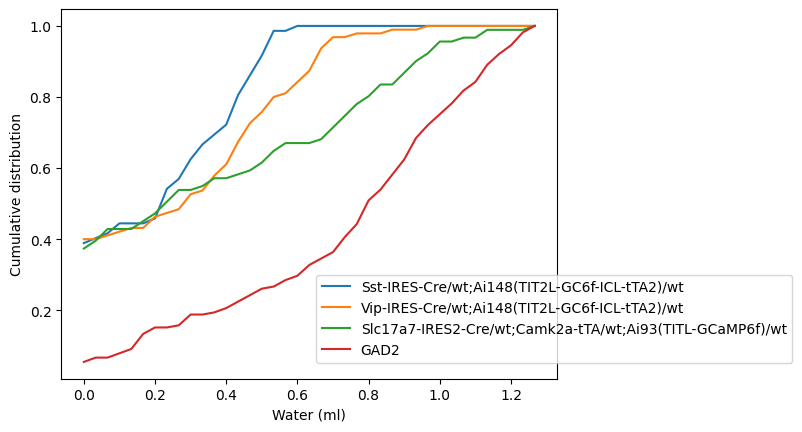

In [26]:
bins = np.linspace(0, 1.3, 40)
genotypes = table.full_genotype.unique()
fig, ax = plt.subplots()
for genotype in genotypes:
    temp_water = table.query("full_genotype == @genotype").water.values
    water_hist, _ = np.histogram(temp_water, bins=bins)
    water_cumhist = np.cumsum(water_hist) / np.sum(water_hist)
    ax.plot(bins[:-1], water_cumhist, label=genotype)
water_hist, _ = np.histogram(gad2_water_volume, bins=bins)
water_cumhist = np.cumsum(water_hist) / np.sum(water_hist)
ax.plot(bins[:-1], water_cumhist, label='GAD2')
ax.legend(loc='upper left', bbox_to_anchor=(0.5,0.3))
ax.set_xlabel('Water (ml)')
ax.set_ylabel('Cumulative distribution')

# Water vs z-drift spread

In [11]:
# Load tables
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
load_fn = zdrift_dir / 'multi_plane_zdrift_vb_multiscope_processed.csv'
table = pd.read_csv(load_fn)
table.set_index('ophys_session_id', drop=True, inplace=True)

In [21]:
# Takes 14 minutes
local_zstack_interval = 0.75
zdrift_spread = []
zdrift_spread_visp = []
zdrift_spread_visl = []
min_cc = []
min_cc_visp = []
min_cc_visl = []

zdrift_osid = []
error_osid = []
for osid in table.index.values:
    try:
        cc, matched_plane_indices, opids = get_zdrift_results_first_last(osid, zdrift_dir)
        cc = np.array(cc)
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
        
        zdrift_spread.append(zdrift_session.var())
        zdrift_osid.append(osid)

        visp_inds = []
        visl_inds = []
        for i in range(len(opids)):
            opid = opids[i]
            if vbms_table.loc[opid].targeted_structure == 'VISp':
                visp_inds.append(i)
            elif vbms_table.loc[opid].targeted_structure == 'VISl':
                visl_inds.append(i)
            else:
                raise ValueError(f'{osid} contains regions other than VISp and VISl')
        visp_inds = np.array(visp_inds)
        visl_inds = np.array(visl_inds)

        zdrift_spread_visp.append(zdrift_session[visp_inds].var())
        zdrift_spread_visl.append(zdrift_session[visl_inds].var())
        
        min_cc.append(np.min(cc))
        min_cc_visp.append(np.min(cc[visp_inds, :]))
        min_cc_visl.append(np.min(cc[visl_inds, :]))
    except:
        error_osid.append(osid)

assert len(zdrift_osid) == len(zdrift_spread) == len(zdrift_spread_visp) == len(min_cc_visl)

In [22]:
table['zdrift_spread'] = None
table['zdrift_spread_visp'] = None
table['zdrift_spread_visl'] = None
table['min_cc'] = None
table['min_cc_visp'] = None
table['min_cc_visl'] = None
for i in range(len(zdrift_osid)):
    osid = zdrift_osid[i]
    table.loc[osid, 'zdrift_spread'] = zdrift_spread[i]
    table.loc[osid, 'zdrift_spread_visp'] = zdrift_spread_visp[i]
    table.loc[osid, 'zdrift_spread_visl'] = zdrift_spread_visl[i]
    table.loc[osid, 'min_cc'] = min_cc[i]
    table.loc[osid, 'min_cc_visp'] = min_cc_visp[i]
    table.loc[osid, 'min_cc_visl'] = min_cc_visl[i]

<AxesSubplot:>

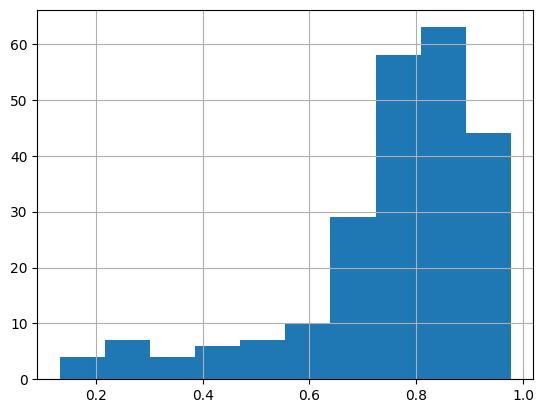

In [71]:
table.min_cc_visl.hist()

<AxesSubplot:>

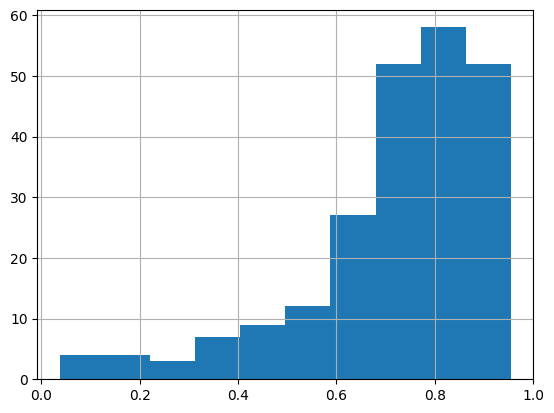

In [14]:
table.min_cc_visp.hist()

In [4]:
filtered_table = table.query('min_cc_visp >=0.7 and min_cc_visl >=0.7')

<AxesSubplot:xlabel='min_cc_visp', ylabel='Frequency'>

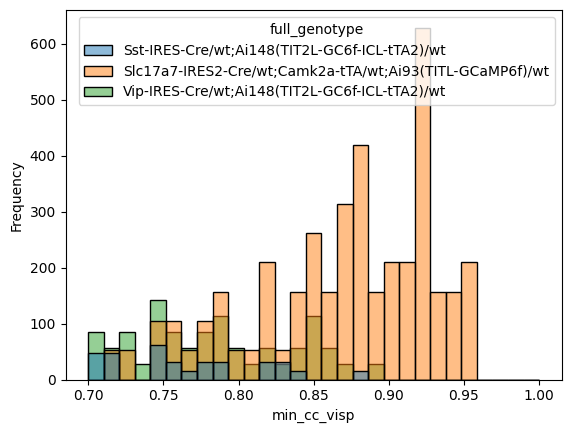

In [8]:
sns.histplot(filtered_table, x='min_cc_visp', hue='full_genotype', stat='frequency', bins=np.linspace(0.7,1,30))


In [23]:
save_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
table.to_pickle(zdrift_dir / save_fn)

### Loading spread vs water calculation

In [12]:
load_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
table = pd.read_pickle(zdrift_dir / load_fn)
filtered_table = table.query('min_cc >= 0.7')

<AxesSubplot:xlabel='water', ylabel='zdrift_spread'>

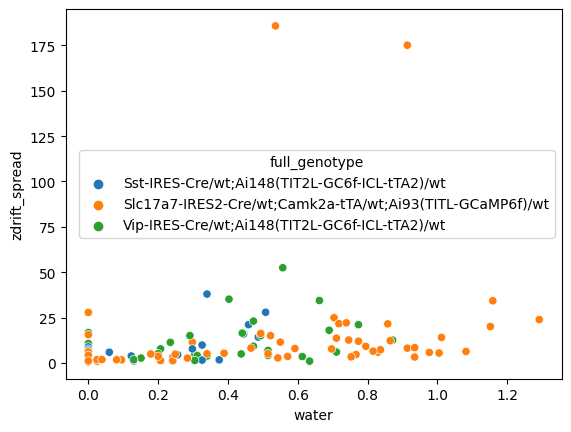

In [9]:

fig, ax = plt.subplots()
sns.scatterplot(table.query('min_cc >= 0.7'), x='water', y='zdrift_spread', hue='full_genotype')

<AxesSubplot:xlabel='water', ylabel='zdrift_spread_visp'>

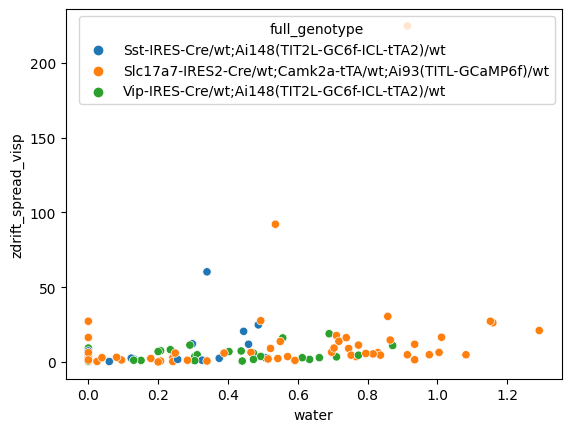

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(filtered_table, x='water', y='zdrift_spread_visp', hue='full_genotype')

<AxesSubplot:xlabel='water', ylabel='zdrift_spread_visl'>

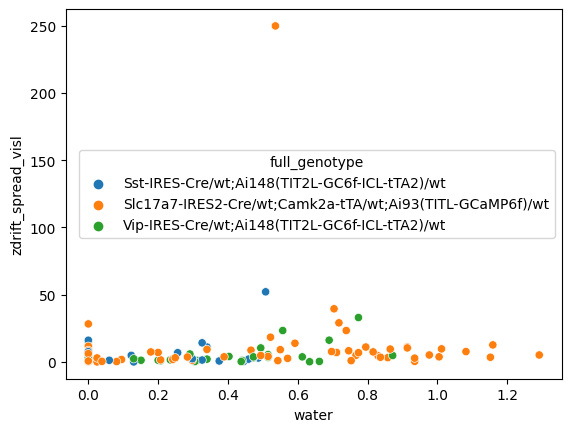

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(filtered_table, x='water', y='zdrift_spread_visl', hue='full_genotype')

In [13]:
table.query('water < 0.4 and zdrift_spread_visl > 50 and min_cc_visl >= 0.7')

,mouse_id,full_genotype,session_type,water,processed,zdrift_spread,zdrift_spread_visp,zdrift_spread_visl,min_cc,min_cc_visp,min_cc_visl
ophys_session_id,,,,,,,,,,,
976167513,482853,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_1_images_A,0.256,True,38.170898,0.667969,70.59375,0.685744,0.685744,0.801965


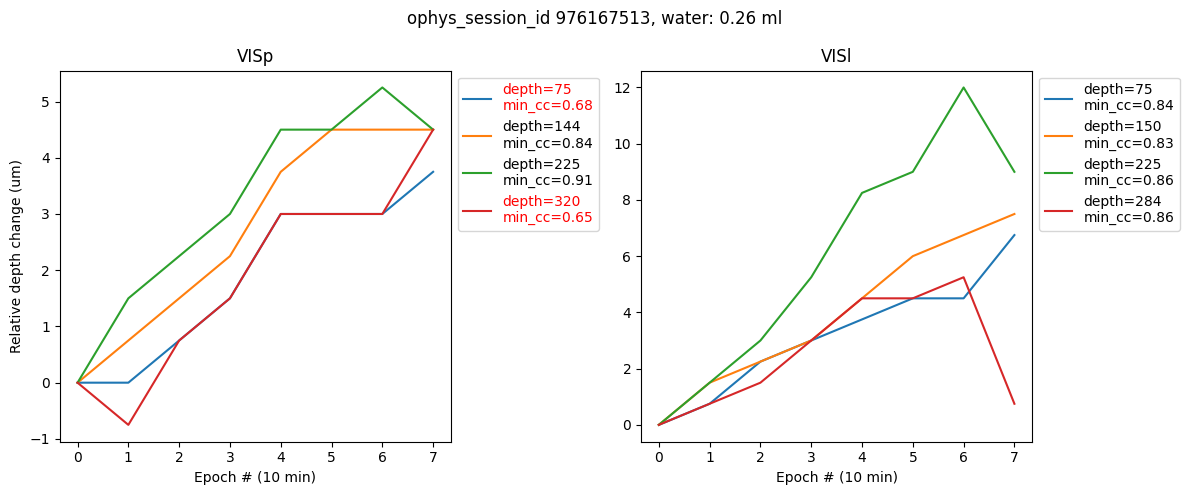

In [14]:
targeted_structures = ['VISp', 'VISl']

osid = 976167513
corrcoef, matched_plane_indices, opids = get_zdrift_results(osid, zdrift_dir)
water = table.loc[osid].water
relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
depth = []
region = []
for opid in opids:
    depth.append(vbms_table.query('ophys_experiment_id == @opid').imaging_depth.values[0])
    region.append(vbms_table.query('ophys_experiment_id == @opid').targeted_structure.values[0])


fig, ax = plt.subplots(1,2, figsize=(12,5))
for i in range(2):
    target = targeted_structures[i]
    temp_inds = np.where(np.array(region) == target)[0]
    temp_depths = np.array(depth)[temp_inds]
    temp_order = np.argsort(temp_depths)
    min_cc = [np.min(corrcoef[ti]) for ti in temp_inds]
    for oi in temp_order:
        ax[i].plot(relative_depth_change[temp_inds[oi]],
                    label=f'depth={temp_depths[oi]}\nmin_cc={min_cc[oi]:.2f}')
    ax[i].set_title(target)
    # ax[i].set_ylim(depth_range[0], depth_range[1])
    legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))
    
    for j, text in enumerate(legend.get_texts()):
        if min_cc[temp_order[j]] < 0.7:
            text.set_color('red')
    ax[i].set_xlabel('Epoch # (10 min)')
ax[0].set_ylabel('Relative depth change (um)')
fig.suptitle(f'ophys_session_id {osid}, water: {water:.2f} ml')
fig.tight_layout()

In [39]:
cc_fl, matched_plane_indices_fl, opids_fl = get_zdrift_results_first_last(osid, zdrift_dir)
zdrift_session_fl = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices_fl])
visp_inds = []
visl_inds = []
for i in range(len(opids_fl)):
    opid = opids_fl[i]
    if vbms_table.loc[opid].targeted_structure == 'VISp':
        visp_inds.append(i)
    elif vbms_table.loc[opid].targeted_structure == 'VISl':
        visl_inds.append(i)
    else:
        raise ValueError(f'{osid} contains regions other than VISp and VISl')
visp_inds = np.array(visp_inds)
visl_inds = np.array(visl_inds)

zdrift_spread_visp_fl = zdrift_session_fl[visp_inds].var()
zdrift_spread_visl_fl = zdrift_session_fl[visl_inds].var()

In [41]:
visl_inds

array([0, 1, 2, 3])

In [37]:
zdrift_session_fl

array([21.  ,  9.  , -2.25,  5.25,  6.  ,  5.25,  5.25,  3.75])

In [40]:
relative_depth_change

[[0.0, 1.5, 3.0, 5.25, 8.25, 9.0, 12.0, 9.0],
 [0.0, 1.5, 2.25, 3.0, 4.5, 6.0, 6.75, 7.5],
 [0.0, 0.75, 1.5, 3.0, 4.5, 4.5, 5.25, 0.75],
 [0.0, 0.75, 2.25, 3.0, 3.75, 4.5, 4.5, 6.75],
 [0.0, 1.5, 2.25, 3.0, 4.5, 4.5, 5.25, 4.5],
 [0.0, 0.75, 1.5, 2.25, 3.75, 4.5, 4.5, 4.5],
 [0.0, -0.75, 0.75, 1.5, 3.0, 3.0, 3.0, 4.5],
 [0.0, 0.0, 0.75, 1.5, 3.0, 3.0, 3.0, 3.75]]

# Huge difference between first-last calculation and episodic mean FOV
- From one example
- Look at them across sessions

In [ ]:
load_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
table = pd.read_pickle(zdrift_dir / load_fn)
filtered_table = table[~table.min_cc.isna()]

In [8]:
filtered_table.columns

Index(['mouse_id', 'full_genotype', 'session_type', 'water', 'processed',
       'zdrift_spread', 'zdrift_spread_visp', 'zdrift_spread_visl', 'min_cc',
       'min_cc_visp', 'min_cc_visl'],
      dtype='object')

In [ ]:
corrcoef, matched_plane_indices, opids = get_zdrift_results(osid, zdrift_dir)

In [22]:
visp_inds

array([2, 3, 4, 6])

In [24]:
np.array(corrcoef).shape

(8, 7)

In [26]:
np.array(matched_plane_indices).shape

(8, 7)

In [27]:
# Takes 9 min
min_cc_episodes = []
min_cc_visp_episodes = []
min_cc_visl_episodes = []
mpi_episodes = []
mpi_visp_episodes = []
mpi_visl_episodes = []
relative_depth_change_episodes = []
relative_depth_change_visp_episodes = []
relative_depth_change_visl_episodes = []
zdrift_spread_episodes = []
zdrift_spread_visp_episodes = []
zdrift_spread_visl_episodes = []

zdrift_episodes_osid = []
error_osid = []
for osid in filtered_table.index.values:
    
    corrcoef, matched_plane_indices, opids = get_zdrift_results(osid, zdrift_dir)
    corrcoef = np.array(corrcoef)
    
    relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
    matched_plane_indices = np.array(matched_plane_indices)
    relative_depth_change = np.array(relative_depth_change)

    visp_inds = []
    visl_inds = []
    for i in range(len(opids)):
        opid = opids[i]
        if vbms_table.loc[opid].targeted_structure == 'VISp':
            visp_inds.append(i)
        elif vbms_table.loc[opid].targeted_structure == 'VISl':
            visl_inds.append(i)
        else:
            raise ValueError(f'{osid} contains regions other than VISp and VISl')
    visp_inds = np.array(visp_inds)
    visl_inds = np.array(visl_inds)

    min_cc_episodes.append(np.min(corrcoef))
    min_cc_visp_episodes.append(np.min(corrcoef[visp_inds, :]))
    min_cc_visl_episodes.append(np.min(corrcoef[visl_inds, :]))

    mpi_episodes.append(matched_plane_indices)
    mpi_visp_episodes.append(matched_plane_indices[visp_inds,:])
    mpi_visl_episodes.append(matched_plane_indices[visl_inds,:])

    relative_depth_change_episodes.append(relative_depth_change)
    relative_depth_change_visp_episodes.append(relative_depth_change[visp_inds,:])
    relative_depth_change_visl_episodes.append(relative_depth_change[visl_inds,:])

    zdrift_spread = relative_depth_change[:,-1].var()
    zdrift_spread_visp = relative_depth_change[visp_inds,-1].var()
    zdrift_spread_visl = relative_depth_change[visl_inds,-1].var()

    zdrift_spread_episodes.append(zdrift_spread)
    zdrift_spread_visp_episodes.append(zdrift_spread_visp)
    zdrift_spread_visl_episodes.append(zdrift_spread_visl)

    zdrift_episodes_osid.append(osid)




In [20]:
len(filtered_table)

142

In [30]:
mpi_episodes[i]

array([[25, 27, 29, 32, 33, 35, 37],
       [25, 27, 29, 32, 33, 35, 38],
       [28, 30, 31, 33, 34, 35, 37],
       [27, 29, 31, 33, 35, 36, 37],
       [25, 26, 29, 32, 33, 34, 36],
       [23, 25, 28, 31, 32, 35, 36],
       [25, 27, 29, 31, 33, 35, 36],
       [22, 25, 27, 29, 31, 33, 36]], dtype=int64)

In [33]:
filtered_table['zdrift_spread_episodes'] = None
filtered_table['zdrift_spread_visp_episodes'] = None
filtered_table['zdrift_spread_visl_episodes'] = None
filtered_table['min_cc_episodes'] = None
filtered_table['min_cc_visp_episodes'] = None
filtered_table['min_cc_visl_episodes'] = None
# filtered_table['matched_plane_indices_episodes'] = None
# filtered_table['matched_plane_indices_visp_episodes'] = None
# filtered_table['matched_plane_indices_visl_episodes'] = None
# filtered_table['relative_depth_change_episodes'] = None
# filtered_table['relative_depth_change_visp_episodes'] = None
# filtered_table['relative_depth_change_visl_episodes'] = None

for i in range(len(zdrift_episodes_osid)):
    osid = zdrift_episodes_osid[i]
    filtered_table.loc[osid, 'zdrift_spread_episodes'] = zdrift_spread_episodes[i]
    filtered_table.loc[osid, 'zdrift_spread_visp_episodes'] = zdrift_spread_visp_episodes[i]
    filtered_table.loc[osid, 'zdrift_spread_visl_episodes'] = zdrift_spread_visl_episodes[i]
    filtered_table.loc[osid, 'min_cc_episodes'] = min_cc_episodes[i]
    filtered_table.loc[osid, 'min_cc_visp_episodes'] = min_cc_visp_episodes[i]
    filtered_table.loc[osid, 'min_cc_visl_episodes'] = min_cc_visl_episodes[i]
    # filtered_table.loc[osid, 'matched_plane_indices_episodes'] = mpi_episodes[i].tolist()
    # filtered_table.loc[osid, 'matched_plane_indices_visp_episodes'] = mpi_visp_episodes[i].tolist()
    # filtered_table.loc[osid, 'matched_plane_indices_visl_episodes'] = mpi_visl_episodes[i].tolist()
    # filtered_table.loc[osid, 'relative_depth_change_episodes'] = relative_depth_change_episodes[i].tolist()
    # filtered_table.loc[osid, 'relative_depth_change_visp_episodes'] = relative_depth_change_visp_episodes[i].tolist()
    # filtered_table.loc[osid, 'relative_depth_change_visl_episodes'] = relative_depth_change_visl_episodes[i].tolist()
    

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_21136\3452621643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_table['zdrift_spread_episodes'] = None
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_21136\3452621643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_table['zdrift_spread_visp_episodes'] = None
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_21136\3452621643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [34]:
save_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
filtered_table.to_pickle(zdrift_dir / save_fn)

<AxesSubplot:xlabel='zdrift_spread', ylabel='zdrift_spread_episodes'>

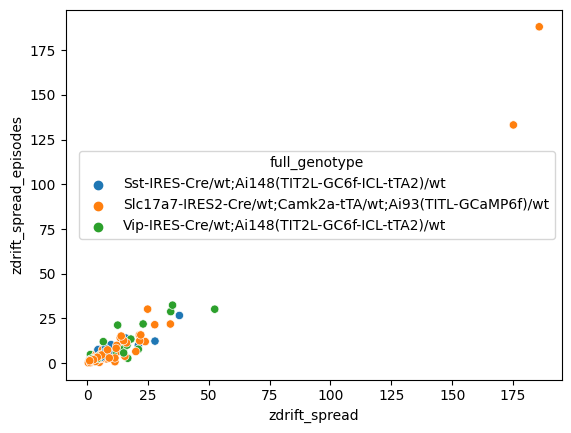

In [36]:
sns.scatterplot(filtered_table, x='zdrift_spread', y='zdrift_spread_episodes', hue='full_genotype')

# 0 water from VB does not mean no water
- Mice for passive sessions had water before the session
- Remove them

In [73]:
load_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
filtered_table = pd.read_pickle(zdrift_dir / load_fn)
# error sessions (imaging error)
error_osid = [1075872563, 906968227]
filtered_table = filtered_table[~filtered_table.index.isin(error_osid)]
active_table = filtered_table[~filtered_table.session_type.str.contains('passive') &
                              ~filtered_table.session_type.str.contains('OPHYS_7')]

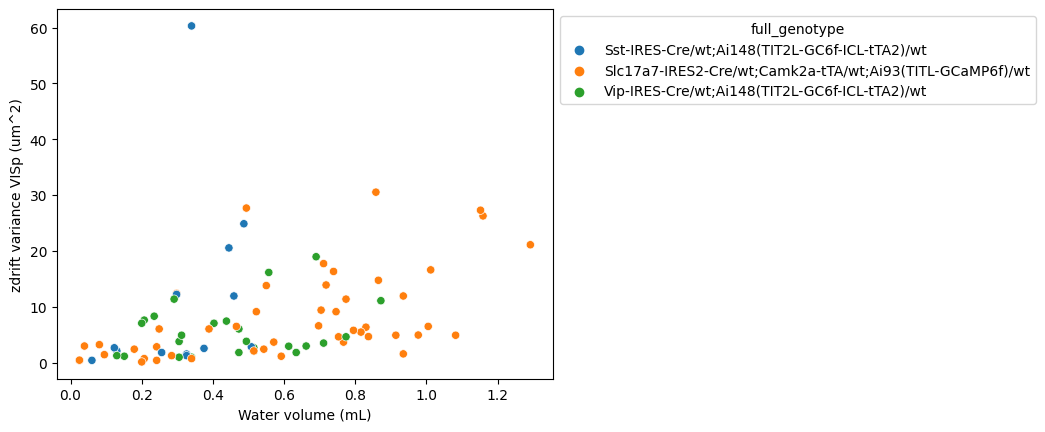

In [78]:
fig, ax = plt.subplots()
sns.scatterplot(active_table, x='water', y='zdrift_spread_visp', hue='full_genotype', ax=ax,
                )
# ax.set_ylim(0, 50)
ax.set_ylabel('zdrift variance VISp (um^2)')
ax.set_xlabel('Water volume (mL)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

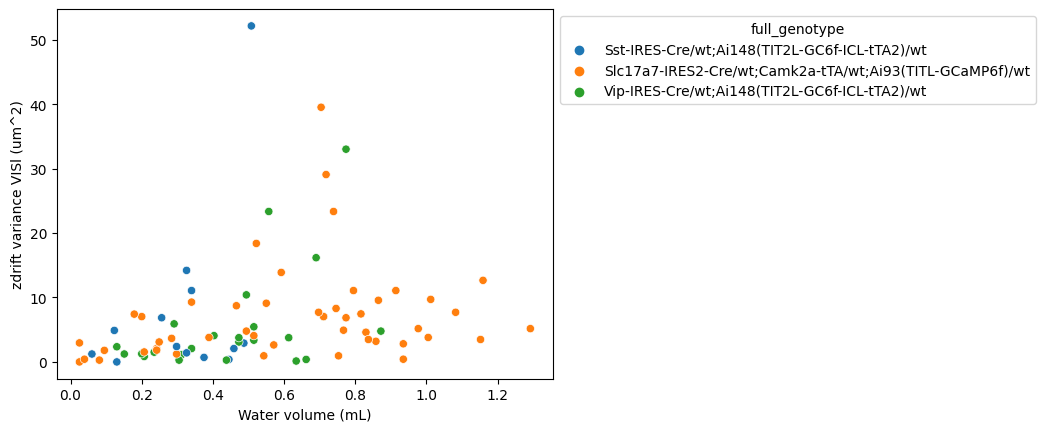

In [77]:
fig, ax = plt.subplots()
sns.scatterplot(active_table, x='water', y='zdrift_spread_visl', hue='full_genotype', ax=ax,
                )
# ax.set_ylim(0, 50)
ax.set_ylabel('zdrift variance VISl (um^2)')
ax.set_xlabel('Water volume (mL)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

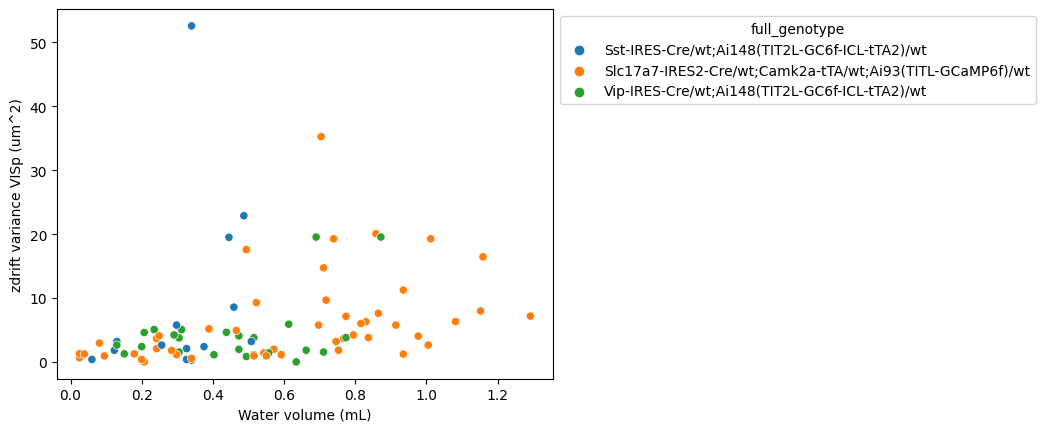

In [96]:
fig, ax = plt.subplots()
sns.scatterplot(active_table, x='water', y='zdrift_spread_visp_episodes', hue='full_genotype', ax=ax,
                )
# ax.set_ylim(0, 50)
ax.set_ylabel('zdrift variance VISp (um^2)')
ax.set_xlabel('Water volume (mL)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

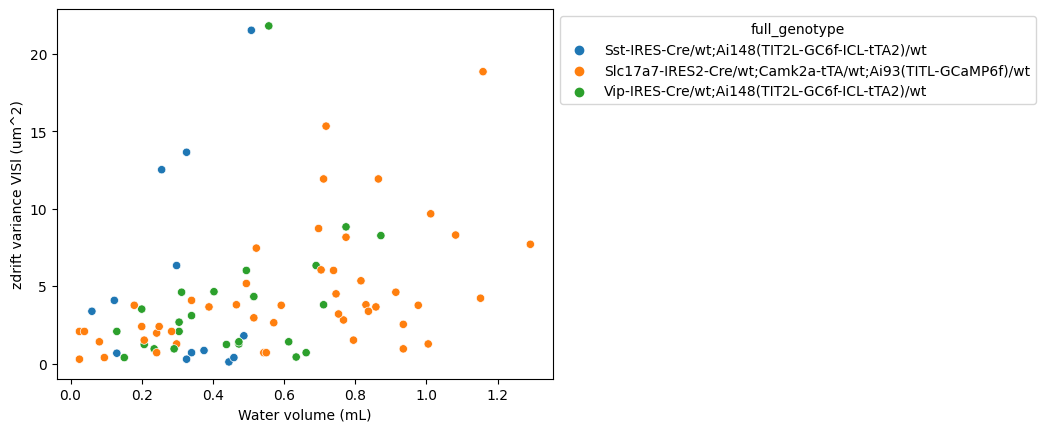

In [95]:
fig, ax = plt.subplots()
sns.scatterplot(active_table, x='water', y='zdrift_spread_visl_episodes', hue='full_genotype', ax=ax,
                )
# ax.set_ylim(0, 50)
ax.set_ylabel('zdrift variance VISl (um^2)')
ax.set_xlabel('Water volume (mL)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(active_table, x='water', y='zdrift_spread', hue='full_genotype', ax=ax)
ax.set_ylim(0, 50)
ax.set_ylabel('zdrift variance (um^2)')
ax.set_xlabel('Water volume (uL)')

### What are the ones with huge z-drift variance?

In [80]:
filtered_table.query('zdrift_spread > 50')

,mouse_id,full_genotype,session_type,water,processed,zdrift_spread,zdrift_spread_visp,zdrift_spread_visl,min_cc,min_cc_visp,...,zdrift_spread_visl_episodes,min_cc_episodes,min_cc_visp_episodes,min_cc_visl_episodes,matched_plane_indices_episodes,matched_plane_indices_visp_episodes,matched_plane_indices_visl_episodes,relative_depth_change_episodes,relative_depth_change_visp_episodes,relative_depth_change_visl_episodes
ophys_session_id,,,,,,,,,,,,,,,,,,,,,
923705570,453990,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_6_images_B,0.557,True,52.444336,16.136719,23.34375,0.725424,0.818334,...,21.796875,0.665393,0.814681,0.665393,None,None,None,None,None,None


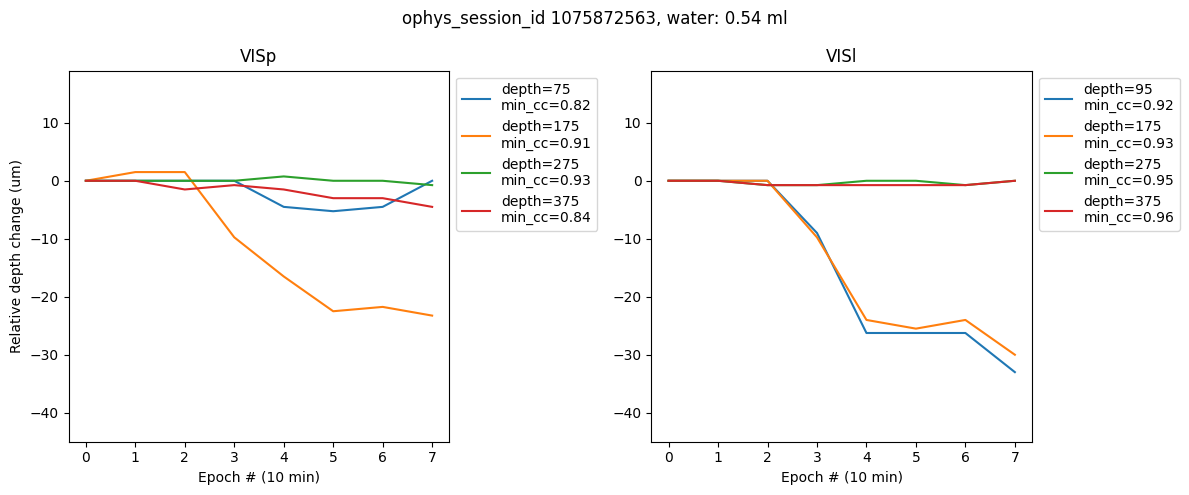

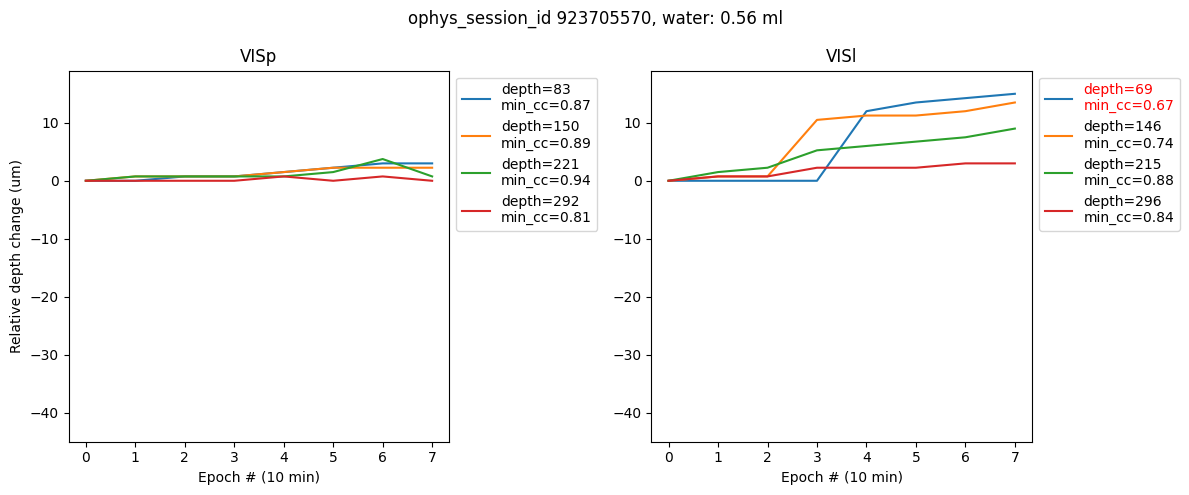

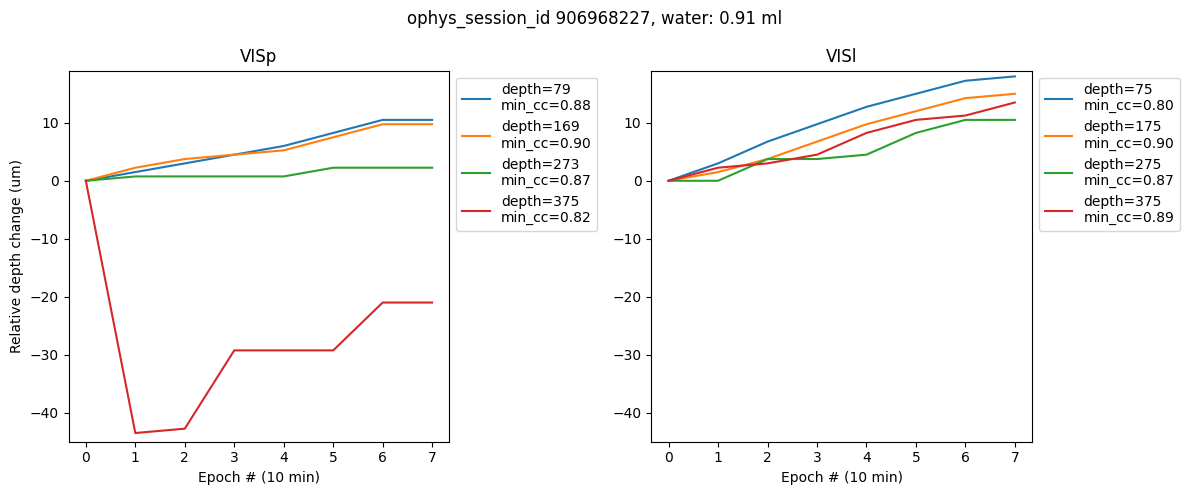

In [64]:
test_osids = filtered_table.query('zdrift_spread > 50').index.values

targeted_structures = ['VISp', 'VISl']

oeid_all = []
cc_all = []
depth_all = []
water_all = []
for osid in test_osids:
    water_all.append(table.query('ophys_session_id == @osid').water.values[0])
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, zdrift_dir)
    relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
    cc_all.append(corrcoef)
    oeid_all.append(oeids)
    depth_all.append(relative_depth_change)

depth_range = (round(np.min([np.min(d) for d in depth_all]))-1, round(np.max([np.max(d) for d in depth_all]))+1)

for osid_i in range(len(test_osids)):
    osid = test_osids[osid_i]
    oeids = oeid_all[osid_i]
    corrcoef = cc_all[osid_i]
    relative_depth_change = depth_all[osid_i]
    water = water_all[osid_i]
    depth = []
    region = []
    for oeid in oeids:
        depth.append(vbms_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0])
        region.append(vbms_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0])
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    for i in range(2):
        target = targeted_structures[i]
        temp_inds = np.where(np.array(region) == target)[0]
        temp_depths = np.array(depth)[temp_inds]
        temp_order = np.argsort(temp_depths)
        min_cc = [np.min(corrcoef[ti]) for ti in temp_inds]
        for oi in temp_order:
            ax[i].plot(relative_depth_change[temp_inds[oi]],
                       label=f'depth={temp_depths[oi]}\nmin_cc={min_cc[oi]:.2f}')
        ax[i].set_title(target)
        ax[i].set_ylim(depth_range[0], depth_range[1])
        legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))
        
        for j, text in enumerate(legend.get_texts()):
            if min_cc[temp_order[j]] < 0.7:
                text.set_color('red')
        ax[i].set_xlabel('Epoch # (10 min)')
    ax[0].set_ylabel('Relative depth change (um)')
    fig.suptitle(f'ophys_session_id {osid}, water: {water:.2f} ml')
    fig.tight_layout()


In [68]:
osid = test_osids[1]
oeids = oeid_all[1]
for oeid in oeids:
    region = vbms_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0]
    depth = vbms_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
    print(f'{oeid}: {region}, {depth}um')

924198897: VISl, 69um
924198887: VISp, 292um
924198895: VISl, 296um
924198893: VISl, 146um
924198891: VISl, 215um
924198889: VISp, 83um
924198885: VISp, 150um
924198883: VISp, 221um


In [69]:
oeid = 924198889
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1018028166\experiment_924198889


In [61]:
osid = 1075872563
corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, zdrift_dir)

In [63]:
oeids

array([1076261149, 1076261147, 1076261146, 1076261143, 1076261142,
       1076261140, 1076261139, 1076261137], dtype=int64)

In [62]:
matched_plane_indices

[array([39, 39, 38, 38, 38, 38, 38, 39], dtype=int64),
 array([78, 78, 78, 66, 43, 43, 43, 34], dtype=int64),
 array([39, 39, 38, 38, 39, 39, 38, 39], dtype=int64),
 array([78, 78, 78, 65, 46, 44, 46, 38], dtype=int64),
 array([41, 41, 39, 40, 39, 37, 37, 35], dtype=int64),
 array([78, 78, 78, 78, 72, 71, 72, 78], dtype=int64),
 array([39, 39, 39, 39, 40, 39, 39, 38], dtype=int64),
 array([76, 78, 78, 63, 54, 46, 47, 45], dtype=int64)]

In [70]:
test_osids

array([1075872563,  923705570,  906968227], dtype=int64)

### Checking these from napari
- 2 examples were due to bad imaging (osid 1075872563 and 906968227)
- 1 example is due to calculating z-drift variance from both regions together

### What's up with data from VISl?
- More spread when water 0.6 ~ 0.8 mL

In [81]:
active_table.query('zdrift_spread_visl > 30')

,mouse_id,full_genotype,session_type,water,processed,zdrift_spread,zdrift_spread_visp,zdrift_spread_visl,min_cc,min_cc_visp,...,zdrift_spread_visl_episodes,min_cc_episodes,min_cc_visp_episodes,min_cc_visl_episodes,matched_plane_indices_episodes,matched_plane_indices_visp_episodes,matched_plane_indices_visl_episodes,relative_depth_change_episodes,relative_depth_change_visp_episodes,relative_depth_change_visl_episodes
ophys_session_id,,,,,,,,,,,,,,,,,,,,,
977760370,482853,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_3_images_A,0.508,True,27.905273,2.8125,52.136719,0.710867,0.710867,...,21.515625,0.540527,0.540527,0.782389,None,None,None,None,None,None
1081070236,547266,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,OPHYS_1_images_A,0.704,True,24.881836,9.386719,39.515625,0.813888,0.813888,...,6.046875,0.85719,0.85719,0.944758,None,None,None,None,None,None
1052752249,528097,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_4_images_B,0.774,True,21.058594,4.605469,33.011719,0.723205,0.723205,...,8.824219,NaN,NaN,0.707266,None,None,None,None,None,None


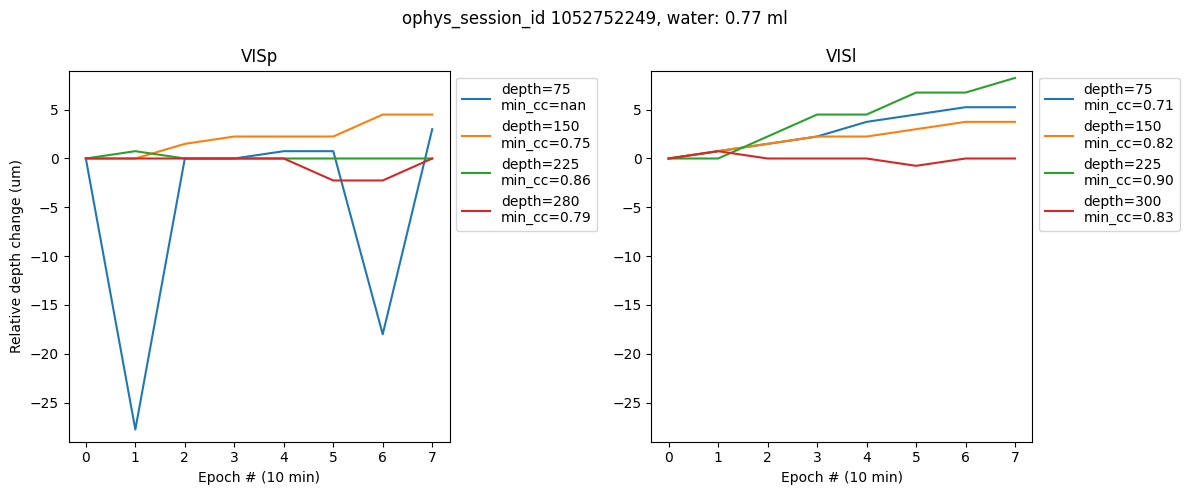

In [91]:
osid = 1052752249
corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, zdrift_dir)
relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
water = table.query('ophys_session_id == @osid').water.values[0]
depth = []
region = []
for oeid in oeids:
    depth.append(vbms_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0])
    region.append(vbms_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0])
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i in range(2):
    target = targeted_structures[i]
    temp_inds = np.where(np.array(region) == target)[0]
    temp_depths = np.array(depth)[temp_inds]
    temp_order = np.argsort(temp_depths)
    min_cc = [np.min(corrcoef[ti]) for ti in temp_inds]
    for oi in temp_order:
        ax[i].plot(relative_depth_change[temp_inds[oi]],
                    label=f'depth={temp_depths[oi]}\nmin_cc={min_cc[oi]:.2f}')
    ax[i].set_title(target)
    ax[i].set_ylim(round(np.min(relative_depth_change))-1, round(np.max(relative_depth_change))+1)
    legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))
    
    for j, text in enumerate(legend.get_texts()):
        if min_cc[temp_order[j]] < 0.7:
            text.set_color('red')
    ax[i].set_xlabel('Epoch # (10 min)')
ax[0].set_ylabel('Relative depth change (um)')
fig.suptitle(f'ophys_session_id {osid}, water: {water:.2f} ml')
fig.tight_layout()


In [92]:
for oeid in oeids:
    region = vbms_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0]
    depth = vbms_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
    print(f'{oeid}: {region}, {depth}um')

1052877371: VISp, 150um
1052877376: VISp, 280um
1052877380: VISl, 75um
1052877373: VISp, 225um
1052877374: VISp, 75um
1052877377: VISl, 150um
1052877379: VISl, 225um
1052877382: VISl, 300um


In [94]:
oeid = 1052877374
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1052096551\experiment_1052877374


In [ ]:
bad_imaging_sessions = [977760370, 1081070236]


## Saving the table

In [5]:
# Load tables
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
load_fn = zdrift_dir / 'multi_plane_zdrift_vb_multiscope_processed.csv'
table = pd.read_csv(load_fn)

In [8]:
osids = table.ophys_session_id.unique()
keep_column_names = ['ophys_experiment_id', 'equipment_name', 'full_genotype',
                     'cre_line', 'indicator', 'ophys_session_id', 'project_code',
                     'imaging_depth', 'targeted_structure',
                     'date_of_acquisition', 'session_type']
vbm_table = exp_table.query('ophys_session_id in @osids').reset_index(drop=False)[keep_column_names]

In [9]:
def _assign_config(x):
    num_unique_regions = len(x.targeted_structure.unique())
    num_planes = len(x) / num_unique_regions
    if num_planes - int(round(num_planes)) != 0:
        num_planes = f'{num_planes:.1f}'
    else:
        num_planes = int(num_planes)
    x['config'] = f'{num_unique_regions}x{num_planes}'
    return x
vbm_table = vbm_table.groupby('ophys_session_id').apply(lambda x: _assign_config(x)).reset_index(drop=True)
vbm_table.config.unique()

array(['2x4'], dtype=object)

In [10]:
bad_imaging_sessions = [977760370, 1081070236]
osids = vbm_table.ophys_session_id.unique()
plane_zdrift_df = pd.DataFrame(columns=['oeid', 'depth', 'region', 'mpi_episodes', 'cc_episodes', 'mpi_fl', 'cc_fl'])
error_osids = []
for osid in osids:
    try:
        assert osid not in bad_imaging_sessions
        corrcoef_episodes, matched_plane_indices_episodes, oeids = get_zdrift_results(osid, zdrift_dir)
        corrcoef_fl, matched_plane_indices_fl, oeids_fl = get_zdrift_results_first_last(osid, zdrift_dir)
        assert (oeids == oeids_fl).all()
        for i, oeid in enumerate(oeids):
            depth, region = get_depth_region_from_db(oeid)
            temp_df = pd.DataFrame({'oeid': oeid, 'depth': depth, 'region': region,
                                    'mpi_episodes': [matched_plane_indices_episodes[i]],
                                    'cc_episodes': [corrcoef_episodes[i]],
                                    'mpi_fl': [matched_plane_indices_fl[i]],
                                    'cc_fl': [corrcoef_fl[i]],
                                    'osid': osid,
                                    }, index=[0])
            plane_zdrift_df = pd.concat([plane_zdrift_df, temp_df], ignore_index=True)
    except:
        error_osids.append(osid)
print(len(error_osids))

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pan

25


In [11]:
print(len(error_osids))

25


In [12]:
print(len(plane_zdrift_df))
print(len(vbm_table))

1864
2064


In [13]:
vbm_zdrift_table = plane_zdrift_df.merge(vbm_table, left_on='oeid',
                                        right_on='ophys_experiment_id',
                                        how='inner')
print(len(vbm_zdrift_table))

1864


In [20]:
vbm_zdrift_table['osid'] = vbm_zdrift_table['osid'].apply(lambda x: int(x))
vbm_zdrift_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,full_genotype,cre_line,indicator,ophys_session_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,config
0,953659756,300,VISl,"[22, 26, 30, 30, 32, 34, 37, 37]","[0.8775670930455506, 0.862272153799377, 0.8609...","[21, 38]","[0.8389432056689461, 0.8685062337926668]",952430817,953659756,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Sst-IRES-Cre,GCaMP6f,952430817,VisualBehaviorMultiscope,300,VISl,2019-09-23 08:45:38.490,OPHYS_2_images_A_passive,2x4
1,953659754,75,VISl,"[22, 26, 30, 30, 32, 34, 37, 38]","[0.9044241177664945, 0.8799589304149958, 0.883...","[21, 39]","[0.8887658224230705, 0.8860860540655202]",952430817,953659754,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Sst-IRES-Cre,GCaMP6f,952430817,VisualBehaviorMultiscope,75,VISl,2019-09-23 08:45:38.490,OPHYS_2_images_A_passive,2x4
2,953659752,225,VISl,"[22, 27, 31, 31, 33, 35, 37, 35]","[0.9083173209898578, 0.912177473092481, 0.9052...","[21, 37]","[0.8811388213190686, 0.8795570450517035]",952430817,953659752,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Sst-IRES-Cre,GCaMP6f,952430817,VisualBehaviorMultiscope,225,VISl,2019-09-23 08:45:38.490,OPHYS_2_images_A_passive,2x4
3,953659749,150,VISl,"[23, 27, 31, 31, 34, 35, 37, 42]","[0.9037365298195349, 0.9427697757131525, 0.942...","[22, 38]","[0.8674766608615554, 0.9322849031354352]",952430817,953659749,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Sst-IRES-Cre,GCaMP6f,952430817,VisualBehaviorMultiscope,150,VISl,2019-09-23 08:45:38.490,OPHYS_2_images_A_passive,2x4
4,953659747,300,VISp,"[20, 24, 27, 29, 30, 36, 39, 40]","[0.8921832284955666, 0.8895522261314999, 0.881...","[20, 40]","[0.8766311781977068, 0.8219071991422875]",952430817,953659747,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Sst-IRES-Cre,GCaMP6f,952430817,VisualBehaviorMultiscope,300,VISp,2019-09-23 08:45:38.490,OPHYS_2_images_A_passive,2x4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,888879676,225,VISl,"[32, 33, 34, 34, 35, 35, 38, 38]","[0.990024695647449, 0.9908885639008473, 0.9910...","[32, 38]","[0.9863937164749423, 0.9834315119970269]",888171877,888879676,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,Slc17a7-IRES2-Cre,GCaMP6f,888171877,VisualBehaviorMultiscope,225,VISl,2019-06-17 12:54:37.113,OPHYS_5_images_B_passive,2x4
1860,888879674,75,VISp,"[32, 34, 35, 36, 37, 37, 38, 38]","[0.9723802144650943, 0.9733779342756438, 0.973...","[33, 39]","[0.9728763699450818, 0.971291281704689]",888171877,888879674,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,Slc17a7-IRES2-Cre,GCaMP6f,888171877,VisualBehaviorMultiscope,75,VISp,2019-06-17 12:54:37.113,OPHYS_5_images_B_passive,2x4
1861,888879671,300,VISp,"[34, 34, 35, 35, 35, 35, 37, 37]","[0.9724504603128633, 0.9698638908724143, 0.968...","[34, 37]","[0.9617774256647985, 0.9555469796084033]",888171877,888879671,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,Slc17a7-IRES2-Cre,GCaMP6f,888171877,VisualBehaviorMultiscope,300,VISp,2019-06-17 12:54:37.113,OPHYS_5_images_B_passive,2x4
1862,888879669,150,VISp,"[34, 35, 36, 37, 37, 38, 39, 39]","[0.9809539025611875, 0.9807092276187783, 0.980...","[34, 39]","[0.9815974812068627, 0.9752809785142464]",888171877,888879669,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,Slc17a7-IRES2-Cre,GCaMP6f,888171877,VisualBehaviorMultiscope,150,VISp,2019-06-17 12:54:37.113,OPHYS_5_images_B_passive,2x4


In [26]:
# get the water information
osids = vbm_zdrift_table.osid.unique()
water_recorded_osid = []
no_water_record_osid = []
water_volume = []
for osid in osids:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    try:
        if 'change_detection' not in session:
            if table.query('ophys_session_id == @osid').session_type.str.contains('OPHYS_7').values[0]:
                water = 0
            elif table.query('ophys_session_id == @osid').session_type.str.contains('passive').values[0]:
                water = 0
            else:
                raise ValueError(f'no change detection data for {osid}')
        else:
            water = session['change_detection']['total_reward_volume']
        water_recorded_osid.append(osid)
        water_volume.append(water)
    except:
        no_water_record_osid.append(osid)
assert len(water_recorded_osid) == len(water_volume)

In [27]:
no_water_record_osid

[]

In [29]:
for i, osid in enumerate(water_recorded_osid):
    vbm_zdrift_table.loc[vbm_zdrift_table.osid==osid, 'water'] = water_volume[i]

In [30]:
zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
save_fn = zdrift_dir/'multiplane_zdrift_vbm.pkl'
vbm_zdrift_table.to_pickle(save_fn)

# Z-drift difference vs depth difference
- To be followed by 240423_multiplane_zdrift_combined.ipynb

# Other data without water

In [5]:
exp_table.project_code.unique()

array(['VisualBehaviorMultiscope', 'LearningmFISHDevelopment', 'U01BFCT',
       'OpenScopeDendriteCoupling', 'VisualBehavior',
       'VisBIntTestDatacube', 'omFISHGad2Meso', 'VisualBehaviorTask1B',
       'MultiscopeSignalNoise', 'omFISHRbp4Meso', 'LearningmFISHTask1A',
       'TaskTrainedNetworksMultiscope',
       'VisualBehaviorMultiscope4areasx2d', 'omFISHSstMeso',
       'VipAxonalV1Phase1', 'MesoscopeDevelopment', 'omFISHCux2Meso',
       'VisualBehaviorIntegrationTest', 'VisualBehaviorDevelopment'],
      dtype=object)

28
['VISp']


<AxesSubplot:>

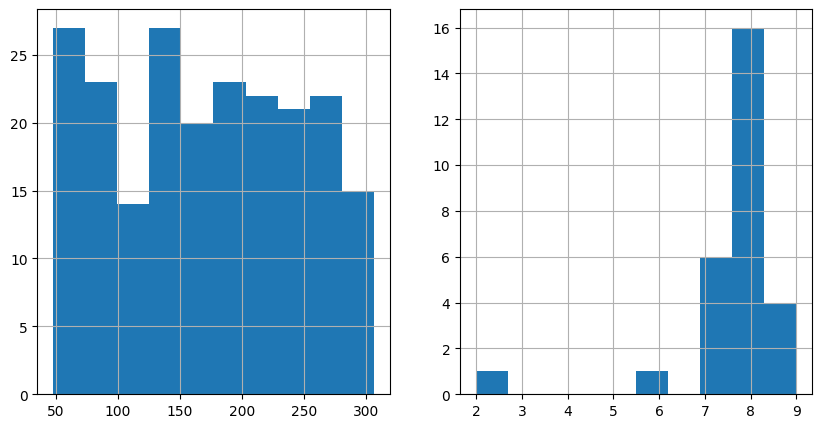

In [32]:
project_code = "omFISHSstMeso"
project_table = exp_table.query(f'project_code == "{project_code}"')
print(len(project_table.ophys_session_id.unique()))
print(project_table.targeted_structure.unique())
fig, ax = plt.subplots(1,2, figsize=(10,5))
project_table.imaging_depth.hist(ax=ax[0])
project_table.groupby('ophys_session_id').size().hist(ax=ax[1])

92
['VISp' 'VISl']


<AxesSubplot:>

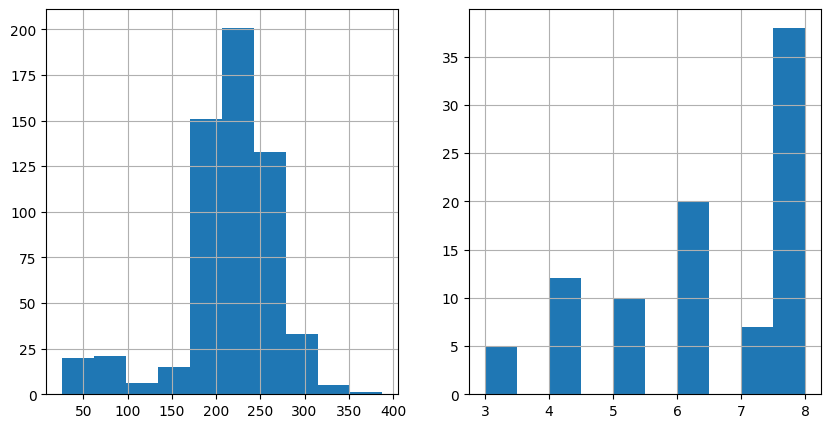

In [31]:
project_code = "omFISHGad2Meso"
project_table = exp_table.query(f'project_code == "{project_code}"')
print(len(project_table.ophys_session_id.unique()))
print(project_table.targeted_structure.unique())
fig, ax = plt.subplots(1,2, figsize=(10,5))
project_table.imaging_depth.hist(ax=ax[0])
project_table.groupby('ophys_session_id').size().hist(ax=ax[1])

21
['VISp']


<AxesSubplot:>

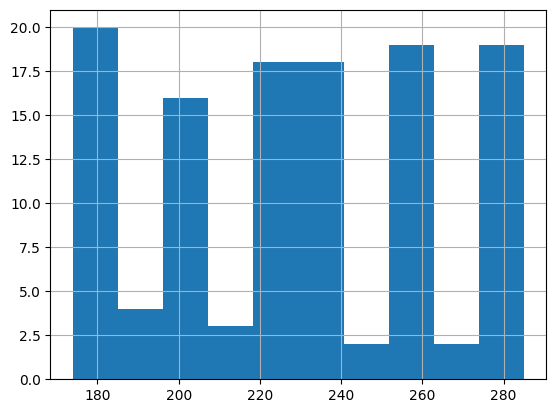

In [28]:
project_code = "omFISHCux2Meso"
project_table = exp_table.query(f'project_code == "{project_code}"')
print(len(project_table.ophys_session_id.unique()))
print(project_table.targeted_structure.unique())
project_table.imaging_depth.hist()

<AxesSubplot:>

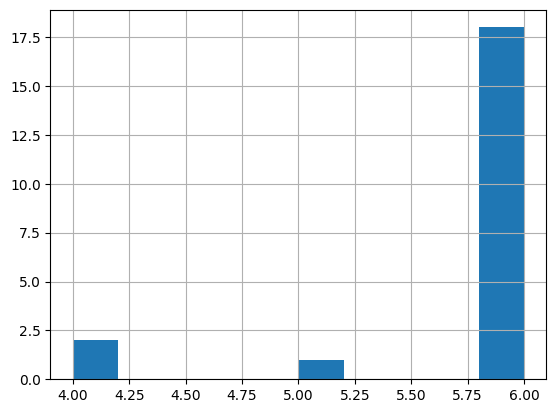

In [29]:
project_table.groupby('ophys_session_id').size().hist()

33
['VISp']


<AxesSubplot:>

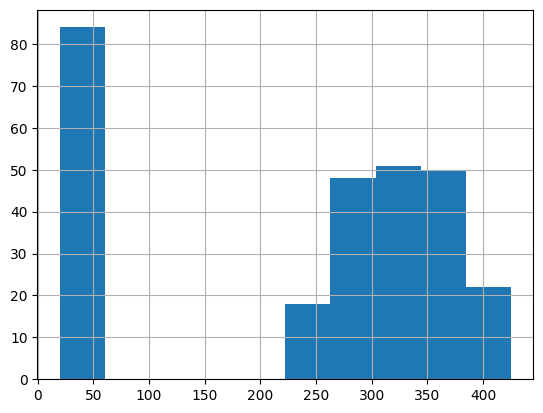

In [26]:
project_code = "omFISHRbp4Meso"
project_table = exp_table.query(f'project_code == "{project_code}"')
print(len(project_table.ophys_session_id.unique()))
print(project_table.targeted_structure.unique())
project_table.imaging_depth.hist()

<AxesSubplot:>

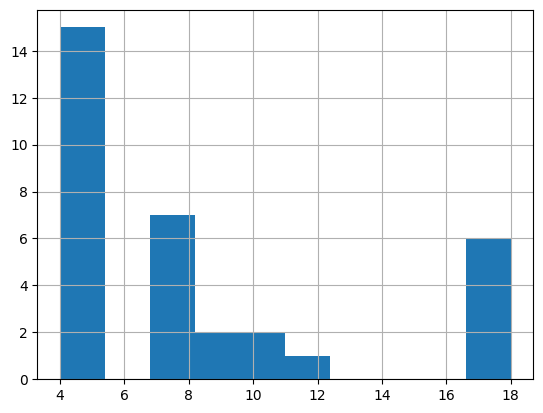

In [27]:
project_table.groupby('ophys_session_id').size().hist()

### Number of sessions
- omFISHSstMeso: filter by 8 planes, 16 sessions
- omFISHGad2Meso: filter by 8 planes, 38 sessions
- omFISHCux2Meso: filter by 6 planes, 18 sessions
- omFISHRbp4Meso: ?? 4 planes, 12 sessions

In [8]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)    
project_codes = ["omFISHSstMeso", "omFISHGad2Meso", "omFISHCux2Meso", "omFISHRbp4Meso"]
num_planes = [8, 8, 6, 4]
omfish_osids = []
for i in range(4):
    code = project_codes[i]
    num_plane = num_planes[i]
    temp_table = table.query(f'project_code == "{code}"')
    temp_table = table.query(f'project_code == "{code}"')
    num_plane_table = temp_table.groupby('ophys_session_id').apply(lambda x: len(x)==num_plane)
    temp_osids = num_plane_table[num_plane_table].index.values
    print(len(temp_osids))
    omfish_osids.extend(temp_osids)
print(len(omfish_osids))

16
38
18
12
84


### Total 83 sessions success
- One with metadata failure (osid: 1194558613)

### Build the table

In [9]:
error_osid = 1194558613
omfish_osids = np.setdiff1d(omfish_osids, error_osid)

In [10]:
keep_column_names = ['ophys_experiment_id', 'equipment_name', 'full_genotype',
                     'cre_line', 'indicator', 'ophys_session_id', 'project_code',
                     'imaging_depth', 'targeted_structure',
                     'date_of_acquisition', 'session_type']
omfish_table = table.query('ophys_session_id in @omfish_osids').reset_index(drop=False)[keep_column_names]


In [12]:
def _assign_config(x):
    num_unique_regions = len(x.targeted_structure.unique())
    num_planes = len(x) / num_unique_regions
    if num_planes - int(round(num_planes)) != 0:
        num_planes = f'{num_planes:.1f}'
    else:
        num_planes = int(num_planes)
    x['config'] = f'{num_unique_regions}x{num_planes}'
    return x
omfish_table = omfish_table.groupby('ophys_session_id').apply(lambda x: _assign_config(x)).reset_index(drop=True)
omfish_table.config.unique()

array(['1x8', '1x4', '2x4', '1x6'], dtype=object)

In [40]:
osids = omfish_table.ophys_session_id.unique()
plane_zdrift_df = pd.DataFrame(columns=['oeid', 'depth', 'region', 'mpi_episodes', 'cc_episodes', 'mpi_fl', 'cc_fl'])
error_osids = []
for osid in osids:
    try:
        corrcoef_episodes, matched_plane_indices_episodes, oeids = get_zdrift_results(osid, zdrift_dir)
        corrcoef_fl, matched_plane_indices_fl, oeids_fl = get_zdrift_results_first_last(osid, zdrift_dir)
        assert (oeids == oeids_fl).all()
        for i, oeid in enumerate(oeids):
            depth, region = get_depth_region_from_db(oeid)
            temp_df = pd.DataFrame({'oeid': oeid, 'depth': depth, 'region': region,
                                    'mpi_episodes': [matched_plane_indices_episodes[i]],
                                    'cc_episodes': [corrcoef_episodes[i]],
                                    'mpi_fl': [matched_plane_indices_fl[i]],
                                    'cc_fl': [corrcoef_fl[i]],
                                    'osid': osid,
                                    }, index=[0])
            plane_zdrift_df = pd.concat([plane_zdrift_df, temp_df], ignore_index=True)
    except:
        error_osids.append(osid)

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pan

In [41]:
error_osids

[1323258655, 1325739462]

In [18]:
omfish_table

,ophys_experiment_id,equipment_name,full_genotype,cre_line,indicator,ophys_session_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,config
0,1339815920,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1339140284,omFISHGad2Meso,348,VISp,2024-03-20 20:10:42.915,STAGE_0,1x8
1,1339815917,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1339140284,omFISHGad2Meso,388,VISp,2024-03-20 20:10:42.915,STAGE_0,1x8
2,1339815915,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1339140284,omFISHGad2Meso,60,VISp,2024-03-20 20:10:42.915,STAGE_0,1x8
3,1339815918,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1339140284,omFISHGad2Meso,94,VISp,2024-03-20 20:10:42.915,STAGE_0,1x8
4,1339815922,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1339140284,omFISHGad2Meso,152,VISp,2024-03-20 20:10:42.915,STAGE_0,1x8
...,...,...,...,...,...,...,...,...,...,...,...,...
575,1205126361,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1204536330,omFISHGad2Meso,240,VISl,2022-09-01 10:12:57.839,STAGE_0,2x4
576,1205126355,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1204536330,omFISHGad2Meso,240,VISp,2022-09-01 10:12:57.839,STAGE_0,2x4
577,1205126356,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1204536330,omFISHGad2Meso,180,VISp,2022-09-01 10:12:57.839,STAGE_0,2x4
578,1205126358,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,Gad2-IRES-Cre,GCaMP7s,1204536330,omFISHGad2Meso,270,VISp,2022-09-01 10:12:57.839,STAGE_0,2x4


In [42]:
plane_zdrift_df

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid
0,1339815924,312,VISp,"[32, 33, 34, 38, 40, 40, 39, 39]","[0.9306152609104624, 0.9396108258906951, 0.942...","[33, 39]","[0.9029833557228162, 0.9325707219912275]",1.339140e+09
1,1339815925,210,VISp,"[29, 30, 31, 35, 38, 37, 37, 37]","[0.8495927107558636, 0.8820253791417942, 0.892...","[29, 36]","[0.7931125096269723, 0.8808719439632199]",1.339140e+09
2,1339815922,152,VISp,"[31, 32, 33, 36, 38, 38, 38, 38]","[0.8440477659727513, 0.8794048890101295, 0.882...","[31, 37]","[0.8016592264394811, 0.8879565813065351]",1.339140e+09
3,1339815915,60,VISp,"[34, 34, 36, 39, 41, 41, 41, 41]","[0.853410312037199, 0.8746182959600995, 0.8855...","[35, 40]","[0.8231362245498672, 0.8821598579377673]",1.339140e+09
4,1339815920,348,VISp,"[34, 35, 35, 38, 39, 39, 39, 39]","[0.9005505150029678, 0.9123146709779918, 0.913...","[35, 39]","[0.8897956735674795, 0.8966660523577388]",1.339140e+09
...,...,...,...,...,...,...,...,...
607,1205126361,240,VISl,"[34, 35, 36, 36, 37, 38, 39, 40]","[0.9389640015732278, 0.942805043100419, 0.9400...","[34, 40]","[0.9327330214823402, 0.9405767200515408]",1.204536e+09
608,1205126359,210,VISl,"[35, 35, 36, 37, 37, 37, 38, 40]","[0.908659161657079, 0.9164254507086349, 0.9117...","[34, 40]","[0.8914086690338673, 0.9073966914455411]",1.204536e+09
609,1205126352,210,VISp,"[35, 36, 37, 38, 37, 38, 38, 38]","[0.9402051909284578, 0.9461745181800995, 0.943...","[35, 39]","[0.9261581040076922, 0.9253247645330461]",1.204536e+09
610,1205126358,270,VISp,"[37, 38, 38, 38, 38, 38, 38, 38]","[0.9316482157471336, 0.9376267283930539, 0.939...","[36, 38]","[0.9116218030055898, 0.9288845789093529]",1.204536e+09


# There are some excess oeids processed.

In [37]:
# osid = from_lims.get_ophys_session_id_for_ophys_experiment_id(excess_oeids[0])
osid = 1311457885
table[table.ophys_session_id == osid]['ophys_session_id']

ophys_experiment_id
1311650182    1311457885
1311650179    1311457885
1311650176    1311457885
1311650173    1311457885
Name: ophys_session_id, dtype: int64

ophys_experiment_id
1288423298    1288252885
1288423292    1288252885
1288423295    1288252885
1288423289    1288252885
Name: ophys_session_id, dtype: int64

In [48]:
excess_osids = []
for oeid in excess_oeids:
    excess_osids.append(from_lims.get_ophys_session_id_for_ophys_experiment_id(oeid))

In [49]:
np.array(excess_osids)

array([1288252885, 1288252885, 1288252885, 1288252885, 1289061402,
       1289061402, 1289061402, 1289061402, 1289281861, 1289281861,
       1289281861, 1289281861, 1290829184, 1290829184, 1290829184,
       1290829184, 1293274571, 1293274571, 1293274571, 1293274571,
       1310643544, 1310643544, 1310643544, 1310643544, 1311138485,
       1311138485, 1311138485, 1311138485, 1311457885, 1311457885,
       1311457885, 1311457885, 1311415972, 1311415972, 1311415972,
       1311415972, 1311791775, 1311791775, 1311791775, 1311791775,
       1312418399, 1312418399, 1312418399, 1312418399, 1312802856,
       1312802856, 1312802856, 1312802856], dtype=int64)

In [47]:
excess_oeids

array([1288423287, 1288423290, 1288423293, 1288423296, 1289152449,
       1289152452, 1289152455, 1289152458, 1289478660, 1289478663,
       1289478666, 1289478669, 1290931947, 1290931950, 1290931955,
       1290931958, 1293372274, 1293372278, 1293372281, 1293372285,
       1310775122, 1310775125, 1310775128, 1310775131, 1311342326,
       1311342330, 1311342333, 1311342336, 1311650169, 1311650174,
       1311650177, 1311650180, 1311650184, 1311650188, 1311650191,
       1311650194, 1311969956, 1311969959, 1311969962, 1311969967,
       1312537960, 1312537965, 1312537968, 1312537971, 1312951818,
       1312951821, 1312951824, 1312951827], dtype=object)

In [28]:
np.intersect1d(table.index.values, excess_oeids)

array([], dtype=object)

In [52]:
len(plane_zdrift_df.query('oeid in @excess_oeids'))

48

In [51]:
plane_zdrift_df.query('oeid in @excess_oeids')

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid
11,1310775131,35,VISp,"[24, 24, 25, 31, 32, 33, 35, 37]","[0.8862675237523151, 0.905618096144721, 0.9230...","[21, 36]","[0.8663958725573324, 0.9240487448033413]",1.310644e+09
12,1310775128,30,VISp,"[20, 23, 27, 30, 32, 33, 35, 36]","[0.8880986442237092, 0.8977767509394136, 0.911...","[19, 38]","[0.8725645728762207, 0.9264347893182372]",1.310644e+09
13,1310775122,20,VISp,"[18, 23, 27, 28, 31, 34, 35, 36]","[0.8929986417603069, 0.9073868223803925, 0.921...","[17, 37]","[0.881760758854066, 0.918598792462615]",1.310644e+09
15,1310775125,25,VISp,"[11, 32, 32, 32, 33, 34, 36, 38]","[0.8371077431534453, 0.8416417341617948, 0.869...","[11, 40]","[0.8288152592282442, 0.8860278018815816]",1.310644e+09
19,1311650188,25,VISp,"[25, 29, 33, 36, 37, 39]","[0.9100786700488228, 0.9162645329478062, 0.921...","[25, 40]","[0.8750553928817878, 0.9197227825635099]",1.311416e+09
21,1311650194,35,VISp,"[26, 29, 32, 34, 36, 38]","[0.933114922901779, 0.9382180470433943, 0.9420...","[24, 38]","[0.9125968233355223, 0.9277079174403893]",1.311416e+09
22,1311650184,20,VISp,"[25, 28, 30, 33, 35, 37]","[0.9201806879731198, 0.9270804339481998, 0.930...","[24, 38]","[0.9025113470063322, 0.9120397850135039]",1.311416e+09
23,1311650191,30,VISp,"[25, 28, 31, 34, 36, 38]","[0.9318728756386191, 0.9378222504146282, 0.941...","[23, 39]","[0.9131987783655785, 0.9327376460395007]",1.311416e+09
26,1311342326,20,VISp,"[22, 26, 30, 34, 36, 36]","[0.9037020255777866, 0.9097907103645636, 0.916...","[20, 39]","[0.8853015519283638, 0.9128660989135358]",1.311138e+09
27,1311342330,30,VISp,"[22, 27, 35, 38, 39, 39]","[0.91661110878807, 0.9165731356780117, 0.90928...","[24, 40]","[0.8299651960954765, 0.8548087513074991]",1.311138e+09


In [50]:
plane_zdrift_df.query('osid in @excess_osids')

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid
8,1310775127,310,VISp,"[30, 34, 36, 36, 37, 38, 40, 40]","[0.803690991581444, 0.8476812726410909, 0.8676...","[32, 42]","[0.7736026129659727, 0.9161713589764343]",1.310644e+09
9,1310775133,370,VISp,"[23, 27, 28, 29, 31, 32, 35, 37]","[0.974762658803857, 0.9787348929792231, 0.9798...","[22, 38]","[0.9684453567629359, 0.9764679866052762]",1.310644e+09
10,1310775130,346,VISp,"[25, 28, 29, 30, 32, 33, 35, 36]","[0.9650783605592623, 0.972867093394431, 0.9740...","[25, 37]","[0.9564866773471861, 0.9649345076043943]",1.310644e+09
11,1310775131,35,VISp,"[24, 24, 25, 31, 32, 33, 35, 37]","[0.8862675237523151, 0.905618096144721, 0.9230...","[21, 36]","[0.8663958725573324, 0.9240487448033413]",1.310644e+09
12,1310775128,30,VISp,"[20, 23, 27, 30, 32, 33, 35, 36]","[0.8880986442237092, 0.8977767509394136, 0.911...","[19, 38]","[0.8725645728762207, 0.9264347893182372]",1.310644e+09
...,...,...,...,...,...,...,...,...
505,1289152455,195,VISp,"[34, 34, 34, 36, 36, 36]","[0.9515559681537099, 0.9503914022616438, 0.949...","[33, 40]","[0.9109874413720341, 0.9083608514514123]",1.289061e+09
506,1289152454,300,VISp,"[34, 34, 34, 35, 35, 35]","[0.9522359427713033, 0.9549980551737987, 0.952...","[32, 33]","[0.9158972708218459, 0.9147906642899452]",1.289061e+09
507,1289152452,175,VISp,"[33, 33, 33, 33, 34, 34]","[0.9553024974893694, 0.9552074994545161, 0.954...","[33, 35]","[0.9211960929416445, 0.9190411727201829]",1.289061e+09
508,1289152449,155,VISp,"[33, 33, 33, 40, 40, 40]","[0.926804008306147, 0.9246895541639871, 0.9220...","[37, 42]","[0.8792440595242412, 0.8789317985885763]",1.289061e+09


In [44]:
excess_osids = np.setdiff1d(plane_zdrift_df.osid.values,
                            omfish_table.ophys_session_id.values)
excess_osids

array([], dtype=float64)

### Excess oeids
- There are some osid-oeid mismatch from lims.
- Half of them are from near surface (can ignore)
- The others... I'm not sure. I can ignore them for now.

In [53]:
# save the results
omfish_zdrift_table = plane_zdrift_df.merge(omfish_table, left_on='oeid',
                                            right_on='ophys_experiment_id',
                                            how='inner')

In [54]:
len(omfish_zdrift_table)

564

In [55]:
zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
save_fn = zdrift_dir/'multiplane_zdrift_omfish.pkl'
omfish_zdrift_table.to_pickle(save_fn)